# VBLL Classification

In this notebook, we walk through implementing VBLL classification models, including out of distribution detection.

If you are new to VBLL models, we recommend checking out the regression notebook first!

In [1]:
!pip install vbll
import vbll

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass

from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn import metrics

from tqdm import tqdm
from matplotlib.pyplot import cm


We will train a small MLP on MNIST. We use Fashion MNIST as an out of distribution dataset. We will also define a simple visualization function, which we will use later.

In [2]:
mnist_train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

mnist_test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())

mnist_ood_dataset = datasets.FashionMNIST(root='data',
                                    train=False,
                                    transform=transforms.ToTensor(),
                                    download=True)

def viz_performance(logs):
  """
  A visualization function that plots losses, accuracies, and out of
  distribution AUROC.

  logs: a dictionary, with keys corresponding to different model evals and values
  corresponding to dicts of results.
  """

  # get list of colors
  color = cm.rainbow(np.linspace(0, 1, len(logs)))

  for i, (k,v) in enumerate(logs.items()):
    # train and val loss
    plt.plot(v['train_loss'], label=k + ' (train)', color=color[i])
    plt.plot(v['val_loss'], label=k + ' (val)', linestyle = '--', color=color[i])
  plt.legend()
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

  for i, (k,v) in enumerate(logs.items()):
    plt.plot([1 - x for x in v['train_acc']], label=k + ' (train)', color=color[i])
    plt.plot([1 - x for x in v['val_acc']], label=k + ' (val)', linestyle='--', color=color[i])

  plt.ylabel('Error rate')
  plt.xlabel('Epoch')
  plt.legend()
  plt.semilogy()
  plt.show()

  for i, (k,v) in enumerate(logs.items()):
    plt.plot(v['ood_auroc'], label=k, color=color[i])
  plt.legend()
  plt.ylabel('OOD AUROC')
  plt.xlabel('Epoch')
  plt.show()


We will first define a simple MLP (with a standard last layer) as a baseline.

In [3]:
class MLP(nn.Module):
  """
  A standard MLP classification model.

  cfg: a config containing model parameters.
  """
  def __init__(self, cfg):
    super(MLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': nn.Linear(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return F.log_softmax(self.params['out_layer'](x), dim=-1)

We have defined a model, and can now write a train loop. In our regression notebook, we write a different train loop for the baseline models and for VBLL models, and highlight the differences. Here, our train function takes are argument in train_cfg indicating whether a model has a VBLL last layer or not. There is a handful of if statements in the code that are different for baseline models and for VBLL models, but the differences are relatively small.

In [4]:
def eval_acc(preds, y):
  map_preds = torch.argmax(preds, dim=1)
  return (map_preds == y).float().mean()

def eval_ood(model, ind_dataloader, ood_dataloader, VBLL=True):
  ind_preds = []
  ood_preds = []

  def get_score(out):
    if VBLL:
      score = out.ood_scores.detach().cpu().numpy()
    else:
      score = torch.max(out, dim=-1)[0].detach().cpu().numpy()
    return score

  for i, (x, y) in enumerate(ind_dataloader):
    x = x.to(device)
    out = model(x)
    ind_preds = np.concatenate((ind_preds, get_score(out)))

  for i, (x, y) in enumerate(ood_dataloader):
    x = x.to(device)
    out = model(x)
    ood_preds = np.concatenate((ood_preds, get_score(out)))

  labels = np.concatenate((np.ones_like(ind_preds)+1, np.ones_like(ind_preds)))
  scores = np.concatenate((ind_preds, ood_preds))
  fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=2)
  return metrics.auc(fpr, tpr)


def train(model, train_cfg):
  """Train a standard classification model with either standard or VBLL models.
  """

  if train_cfg.VBLL:
    # for VBLL models, set weight decay to zero on last layer
    param_list = [
        {'params': model.params.in_layer.parameters(), 'weight_decay': train_cfg.WD},
        {'params': model.params.core.parameters(), 'weight_decay': train_cfg.WD},
        {'params': model.params.out_layer.parameters(), 'weight_decay': 0.}
    ]
  else:
    param_list = model.parameters()
    loss_fn = nn.CrossEntropyLoss() # define loss function only for non-VBLL model

  optimizer = train_cfg.OPT(param_list,
                            lr=train_cfg.LR,
                            weight_decay=train_cfg.WD)

  dataloader = DataLoader(mnist_train_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(mnist_test_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)
  ood_dataloader = DataLoader(mnist_ood_dataset, batch_size = train_cfg.BATCH_SIZE, shuffle=True)

  output_metrics = {
      'train_loss': [],
      'val_loss': [],
      'train_acc': [],
      'val_acc': [],
      'ood_auroc': []
  }

  for epoch in range(train_cfg.NUM_EPOCHS):
    model.train()
    running_loss = []
    running_acc = []

    for train_step, data in enumerate(dataloader):
      optimizer.zero_grad()
      x = data[0].to(device)
      y = data[1].to(device)

      out = model(x)
      if train_cfg.VBLL:
        loss = out.train_loss_fn(y)
        probs = out.predictive.probs
        acc = eval_acc(probs, y).item()
      else:
        loss = loss_fn(out, y)
        acc = eval_acc(out, y).item()

      running_loss.append(loss.item())
      running_acc.append(acc)

      loss.backward()
      optimizer.step()

    output_metrics['train_loss'].append(np.mean(running_loss))
    output_metrics['train_acc'].append(np.mean(running_acc))

    if epoch % train_cfg.VAL_FREQ == 0:
      running_val_loss = []
      running_val_acc = []

      with torch.no_grad():
        model.eval()
        for test_step, data in enumerate(val_dataloader):
          x = data[0].to(device)
          y = data[1].to(device)

          out = model(x)
          if train_cfg.VBLL:
            loss = out.val_loss_fn(y)
            probs = out.predictive.probs
            acc = eval_acc(probs, y).item()
          else:
            loss = loss_fn(out, y)
            acc = eval_acc(out, y).item()

          running_val_loss.append(loss.item())
          running_val_acc.append(acc)

        output_metrics['val_loss'].append(np.mean(running_val_loss))
        output_metrics['val_acc'].append(np.mean(running_val_acc))
      output_metrics['ood_auroc'].append(eval_ood(model, val_dataloader, ood_dataloader, VBLL=train_cfg.VBLL))
      print('Epoch: {:2d}, train loss: {:4.4f}'.format(epoch, np.mean(running_loss)))
      print('Epoch: {:2d}, valid loss: {:4.4f}'.format(epoch, np.mean(np.mean(running_val_loss))))
  return output_metrics

outputs = {}

We can now train a baseline MLP:

In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

class train_cfg:
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 1e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = False

class cfg:
  IN_FEATURES = 784
  HIDDEN_FEATURES = 128
  OUT_FEATURES = 10
  NUM_LAYERS = 2


model = MLP(cfg()).to(device)
outputs['MLP'] = train(model, train_cfg())

Epoch:  0, train loss: 0.5983
Epoch:  0, valid loss: 0.2720
Epoch:  1, train loss: 0.2489
Epoch:  1, valid loss: 0.2165
Epoch:  2, train loss: 0.1990
Epoch:  2, valid loss: 0.1779
Epoch:  3, train loss: 0.1639
Epoch:  3, valid loss: 0.1543
Epoch:  4, train loss: 0.1395
Epoch:  4, valid loss: 0.1355
Epoch:  5, train loss: 0.1209
Epoch:  5, valid loss: 0.1291
Epoch:  6, train loss: 0.1065
Epoch:  6, valid loss: 0.1129
Epoch:  7, train loss: 0.0937
Epoch:  7, valid loss: 0.1053
Epoch:  8, train loss: 0.0838
Epoch:  8, valid loss: 0.1009
Epoch:  9, train loss: 0.0752
Epoch:  9, valid loss: 0.1056
Epoch: 10, train loss: 0.0678
Epoch: 10, valid loss: 0.0980
Epoch: 11, train loss: 0.0609
Epoch: 11, valid loss: 0.0911
Epoch: 12, train loss: 0.0548
Epoch: 12, valid loss: 0.0893
Epoch: 13, train loss: 0.0528
Epoch: 13, valid loss: 0.0915
Epoch: 14, train loss: 0.0465
Epoch: 14, valid loss: 0.0886
Epoch: 15, train loss: 0.0416
Epoch: 15, valid loss: 0.0868
Epoch: 16, train loss: 0.0385
Epoch: 16,

Now, let's define a VBLL model. Note that the only difference is the out_layer switching from a linear layer to a VBLLClassificationD layer.

We also no longer need to include an output softmax, since that is included in the VBLL classification layer.

In [6]:
class DiscVBLLMLP(nn.Module):
  def __init__(self, cfg):
    super(DiscVBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': vbll.DiscClassification(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, parameterization = cfg.PARAM, return_ood=cfg.RETURN_OOD, prior_scale=cfg.PRIOR_SCALE),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [7]:
class train_cfg:
  NUM_EPOCHS = 30
  BATCH_SIZE = 512
  LR = 3e-3
  WD = 1e-4
  OPT = torch.optim.AdamW
  CLIP_VAL = 1
  VAL_FREQ = 1
  VBLL = True

class cfg:
    IN_FEATURES = 784
    HIDDEN_FEATURES = 128
    OUT_FEATURES = 10
    NUM_LAYERS = 2
    REG_WEIGHT = 1./mnist_train_dataset.__len__()
    PARAM = 'diagonal'
    RETURN_OOD = True
    PRIOR_SCALE = 1.

disc_vbll_model = DiscVBLLMLP(cfg()).to(device)
outputs['DiscVBLL'] = train(disc_vbll_model, train_cfg())

Epoch:  0, train loss: 3.6502
Epoch:  0, valid loss: 0.9098
Epoch:  1, train loss: 2.0208
Epoch:  1, valid loss: 0.6610
Epoch:  2, train loss: 1.4807
Epoch:  2, valid loss: 0.3486
Epoch:  3, train loss: 1.1293
Epoch:  3, valid loss: 0.2595
Epoch:  4, train loss: 0.9065
Epoch:  4, valid loss: 0.1816
Epoch:  5, train loss: 0.7412
Epoch:  5, valid loss: 0.2053
Epoch:  6, train loss: 0.6349
Epoch:  6, valid loss: 0.1367
Epoch:  7, train loss: 0.5440
Epoch:  7, valid loss: 0.1794
Epoch:  8, train loss: 0.4800
Epoch:  8, valid loss: 0.1147
Epoch:  9, train loss: 0.4257
Epoch:  9, valid loss: 0.1342
Epoch: 10, train loss: 0.3846
Epoch: 10, valid loss: 0.1473
Epoch: 11, train loss: 0.3472
Epoch: 11, valid loss: 0.1377
Epoch: 12, train loss: 0.3253
Epoch: 12, valid loss: 0.1053
Epoch: 13, train loss: 0.3079
Epoch: 13, valid loss: 0.1232
Epoch: 14, train loss: 0.2750
Epoch: 14, valid loss: 0.1231
Epoch: 15, train loss: 0.2691
Epoch: 15, valid loss: 0.1170
Epoch: 16, train loss: 0.2540
Epoch: 16,

We can also train a VBLL MLP with a Generative VBLL last layer. Note that we are only changing the output layer. We can use the same config.

Note also that the train loss is not directly comparable between the generative and discriminative models.

In [8]:
class GenVBLLMLP(nn.Module):
  def __init__(self, cfg):
    super(GenVBLLMLP, self).__init__()

    self.params = nn.ModuleDict({
      'in_layer': nn.Linear(cfg.IN_FEATURES, cfg.HIDDEN_FEATURES),
      'core': nn.ModuleList([nn.Linear(cfg.HIDDEN_FEATURES, cfg.HIDDEN_FEATURES) for i in range(cfg.NUM_LAYERS)]),
      'out_layer': vbll.GenClassification(cfg.HIDDEN_FEATURES, cfg.OUT_FEATURES, cfg.REG_WEIGHT, parameterization = cfg.PARAM, return_ood=cfg.RETURN_OOD, prior_scale=cfg.PRIOR_SCALE),
    })
    self.activations = nn.ModuleList([nn.ELU() for i in range(cfg.NUM_LAYERS)])
    self.cfg = cfg

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.params['in_layer'](x)

    for layer, ac in zip(self.params['core'], self.activations):
      x = ac(layer(x))

    return self.params['out_layer'](x)

In [9]:
gen_vbll_model = GenVBLLMLP(cfg()).to(device)
outputs['GenVBLL'] = train(gen_vbll_model, train_cfg())

Epoch:  0, train loss: 1052.9993
Epoch:  0, valid loss: 1.0089
Epoch:  1, train loss: 411.9979
Epoch:  1, valid loss: 0.4640
Epoch:  2, train loss: 224.6902
Epoch:  2, valid loss: 0.3177
Epoch:  3, train loss: 143.0866
Epoch:  3, valid loss: 0.2567
Epoch:  4, train loss: 99.4332
Epoch:  4, valid loss: 0.2219
Epoch:  5, train loss: 73.2394
Epoch:  5, valid loss: 0.1944
Epoch:  6, train loss: 56.1805
Epoch:  6, valid loss: 0.1693
Epoch:  7, train loss: 44.3615
Epoch:  7, valid loss: 0.1641
Epoch:  8, train loss: 35.9223
Epoch:  8, valid loss: 0.1493
Epoch:  9, train loss: 29.5990
Epoch:  9, valid loss: 0.1312
Epoch: 10, train loss: 24.7483
Epoch: 10, valid loss: 0.1246
Epoch: 11, train loss: 20.9903
Epoch: 11, valid loss: 0.1157
Epoch: 12, train loss: 17.9761
Epoch: 12, valid loss: 0.1115
Epoch: 13, train loss: 15.5314
Epoch: 13, valid loss: 0.1111
Epoch: 14, train loss: 13.5226
Epoch: 14, valid loss: 0.1042
Epoch: 15, train loss: 11.8618
Epoch: 15, valid loss: 0.0962
Epoch: 16, train lo

And finally, we can visualize performance of all models.

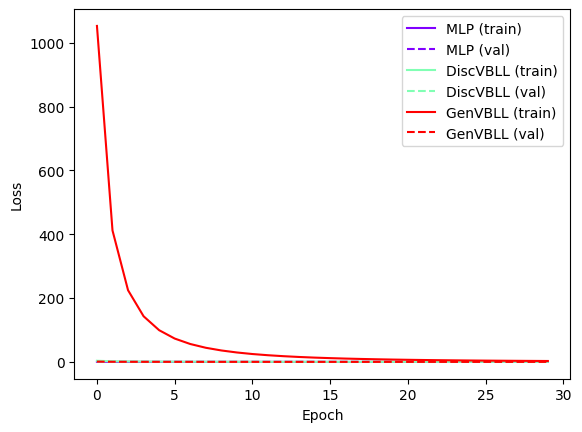

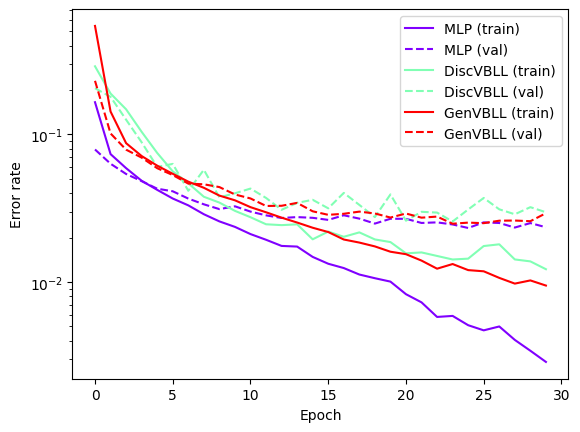

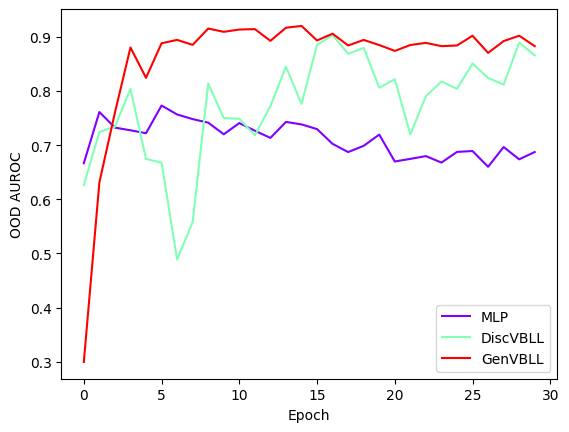

In [10]:
viz_performance(outputs)